In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [2]:
print(tf.__version__) #version check

2.6.0


# 1. Load cifar10 dataset

In [3]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data load
x_train, x_test = x_train / 255.0, x_test / 255.0 # data preprocessing

In [4]:
print(x_train.shape, y_train.shape) #check your data shape

(50000, 32, 32, 3) (50000, 1)


# Cifar 데이터 시각화

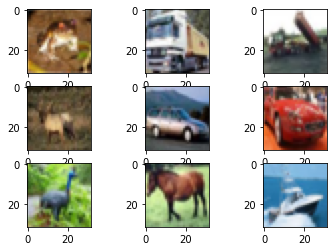

In [5]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(3,3)
for idx in range(9):
  axes[idx//3, idx%3].imshow(x_train[idx])

# 2. Build your Convolutional Neural Network!

In [6]:
def build_CNN():
  CNN = tf.keras.models.Sequential()
  CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
  CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
  CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Flatten())
  CNN.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
  CNN.add(tf.keras.layers.Dense(10, activation='softmax'))

  return CNN

In [7]:
your_cnn = build_CNN()
your_cnn.build([None, 32, 32, 3])

In [8]:
your_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
history = your_cnn.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
1250/1250 [==============================] - 22s 16ms/step - loss: 1.4567 - accuracy: 0.4696 - val_loss: 1.2025 - val_accuracy: 0.5650
Epoch 2/20
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9640 - accuracy: 0.6611 - val_loss: 0.8781 - val_accuracy: 0.6902
Epoch 3/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.7507 - accuracy: 0.7375 - val_loss: 0.7838 - val_accuracy: 0.7262
Epoch 4/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.6082 - accuracy: 0.7843 - val_loss: 0.7829 - val_accuracy: 0.7324
Epoch 5/20
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4776 - accuracy: 0.8309 - val_loss: 0.7710 - val_accuracy: 0.7560
Epoch 6/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3737 - accuracy: 0.8704 - val_loss: 0.8093 - val_accuracy: 0.7548
Epoch 7/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2882 - accuracy: 0.8985 - val_loss: 0.9354 -

[1.7853223085403442, 0.7299000024795532]

In [11]:
your_cnn.evaluate(x_test,  y_test, verbose=2) # 테스트

313/313 - 2s - loss: 1.7853 - accuracy: 0.7299


[1.7853223085403442, 0.7299000024795532]

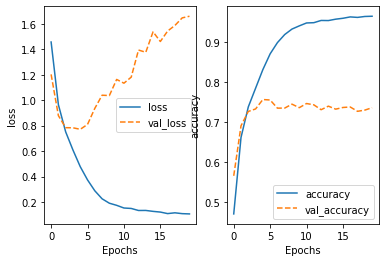

In [10]:
fig = plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], '-', label='loss')
plt.plot(history.epoch, history.history['val_loss'], '--', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
fig = plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], '-', label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '--', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# 3.Train your model smarter

모델 학습 시 조금 더 똑똑하게 학습하기 위한 유용한 도구들이 존재합니다.
그 중 하나는 Keras에서는 [Callback함수를 활용](https://https://www.tensorflow.org/guide/keras/train_and_evaluate#%EC%BD%9C%EB%B0%B1_%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0)하는 것입니다.

- EarlyStopping : validation loss가 일정 이상 줄어들지 않으면, 학습을 정지합니다.
- ModelCheckpoint : 학습 중 모델을 일정 주기로 모델을 저장합니다.
- TensorBoard : [TensorBoard](https://www.tensorflow.org/tensorboard)에서 읽을 수 있는 형태로 log를 저장합니다.

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=5,
            verbose=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="step3_{epoch}.h5",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]

### Add Dropout layers

모델의 성능을 개선하기 위해 스케일을 높일 경우 쉽게 과대적합될 수 있습니다.
이것을 피하기 위해 몇 가지 Regularization 기법을 쓸 수 있습니다.
이번에는 Dropout layer를 추가할 것입니다.

In [16]:
def add_dropout():
  CNN = tf.keras.models.Sequential()
  CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
  CNN.add(tf.keras.layers.Dropout(0.25))
  CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
  CNN.add(tf.keras.layers.Dropout(0.25))
  CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  CNN.add(tf.keras.layers.Dropout(0.25))
  CNN.add(tf.keras.layers.Flatten())
  CNN.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
  CNN.add(tf.keras.layers.Dense(10, activation='softmax'))
  return CNN

In [19]:
CNN_with_dropout = add_dropout()
CNN_with_dropout.build([None, 32, 32, 3])

In [20]:
CNN_with_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = CNN_with_dropout.fit(x_train, y_train, epochs=20, validation_split=0.2,
                               callbacks=callbacks)

Epoch 1/20
1250/1250 [==============================] - 22s 17ms/step - loss: 1.6470 - accuracy: 0.3920 - val_loss: 1.2368 - val_accuracy: 0.5489

Epoch 00001: val_loss did not improve from 0.86454
Epoch 2/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1511 - accuracy: 0.5889 - val_loss: 0.9741 - val_accuracy: 0.6546

Epoch 00002: val_loss did not improve from 0.86454
Epoch 3/20
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9453 - accuracy: 0.6632 - val_loss: 0.8235 - val_accuracy: 0.7088

Epoch 00003: val_loss improved from 0.86454 to 0.82347, saving model to mymodel_3
INFO:tensorflow:Assets written to: mymodel_3/assets
Epoch 4/20
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8265 - accuracy: 0.7124 - val_loss: 0.7876 - val_accuracy: 0.7239

Epoch 00004: val_loss improved from 0.82347 to 0.78757, saving model to mymodel_4
INFO:tensorflow:Assets written to: mymodel_4/assets
Epoch 5/20
1250/1250 [====================

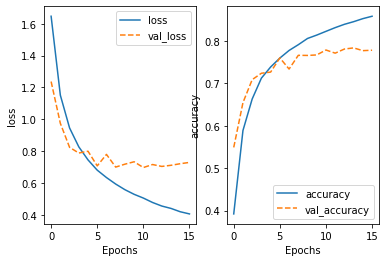

In [21]:
fig = plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], '-', label='loss')
plt.plot(history.epoch, history.history['val_loss'], '--', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
fig = plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], '-', label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '--', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [22]:
path_to_best_model = "path/to/best/model"
best_model = tf.keras.models.load_model(path_to_best_model)
best_model.evaluate(x_test,  y_test, verbose=2)

313/313 - 2s - loss: 0.7225 - accuracy: 0.7704


[0.7224635481834412, 0.7703999876976013]

# 4. 데이터 파이프라인과 데이터증폭

텐서플로우 데이터 파이프라인은 학습데이터를 design하기 위한 멋진 인터페이스를 제공합니다. 주로 다음과 같은 절차를 밟습니다.

- step 1. 텐서플로우 데이터셋 객체를 만든다.
- step 2. map 함수로 데이터를 전처리한다.
- step 3. 데이터파이프라인을 최적화한다.

In [44]:
# step 1. 텐서플로우 데이터셋 객체를 만듭니다.

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
num_train = len(train_ds)
print("학습데이터 수 : ", num_train)

# 학습셋, 검증셋 스플릿
val_ds = train_ds.take(int(num_train*0.2))
train_ds = train_ds.skip(int(num_train*0.2))

# 테스트셋
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

학습데이터 수 :  50000


In [45]:
print(len(train_ds), len(val_ds), len(test_ds))

40000 10000 10000


In [46]:
# step 2. 데이터를 전처리합니다.

def augment(img,label):
    img = tf.image.resize_with_crop_or_pad(img, 32 + 4, 32 + 4) 
    # Random crop back to the original size
    img = tf.image.random_crop(img, size=[32, 32, 3])
    img = tf.image.random_brightness(img, 0.15)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    return img, label

train_ds = train_ds.map(augment)

In [47]:
# step 3. 파이프라인을 최적화해줍니다.

train_ds = train_ds.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(64)

In [48]:
CNN_with_dropout = add_dropout()
CNN_with_dropout.build([None, 32, 32, 3])
CNN_with_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=5,
            verbose=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="step4_{epoch}.h5",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
history = CNN_with_dropout.fit(train_ds, epochs=40, validation_data=val_ds,
                               callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 19s 28ms/step - loss: 1.9327 - accuracy: 0.2865 - val_loss: 1.5415 - val_accuracy: 0.4415

Epoch 00001: val_loss improved from inf to 1.54149, saving model to mymodel_1.h5
Epoch 2/40
625/625 [==============================] - 18s 28ms/step - loss: 1.4530 - accuracy: 0.4788 - val_loss: 1.2309 - val_accuracy: 0.5673

Epoch 00002: val_loss improved from 1.54149 to 1.23086, saving model to mymodel_2.h5
Epoch 3/40
625/625 [==============================] - 18s 27ms/step - loss: 1.1980 - accuracy: 0.5777 - val_loss: 1.0466 - val_accuracy: 0.6401

Epoch 00003: val_loss improved from 1.23086 to 1.04663, saving model to mymodel_3.h5
Epoch 4/40
625/625 [==============================] - 18s 28ms/step - loss: 1.0659 - accuracy: 0.6270 - val_loss: 0.9221 - val_accuracy: 0.6768

Epoch 00004: val_loss improved from 1.04663 to 0.92207, saving model to mymodel_4.h5
Epoch 5/40
625/625 [==============================] - 18s 28ms/step - loss: 0.9700 -

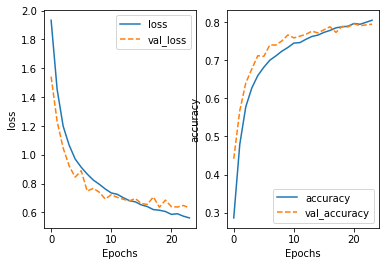

In [50]:
fig = plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], '-', label='loss')
plt.plot(history.epoch, history.history['val_loss'], '--', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
fig = plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], '-', label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '--', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [51]:
path_to_best_model = "path/to/best/model"
best_model = tf.keras.models.load_model(path_to_best_model)
best_model.evaluate(x_test,  y_test, verbose=2)

157/157 [==============================] - 2s 9ms/step - loss: 0.6451 - accuracy: 0.7904


[0.6451171040534973, 0.7904000282287598]

# 5. Learning rate scheduler

학습률(learning rate)은 가장 중요한 hyper-parameter 중 하나입니다. 일반적으로 학습초기부터 끝까지 동일한 학습률을 쓰는 것보다 약간씩 감소시키는 것이 더 좋을 수도 있습니다.

In [55]:
CNN_with_dropout = add_dropout()
CNN_with_dropout.build([None, 32, 32, 3])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

CNN_with_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

class lrHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.lr = []        
    def on_epoch_begin(self, epoch, logs):
        self.lr.append(float(tf.keras.backend.get_value(self.model.optimizer.lr)))

lr_hist = lrHistory()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=5,
            verbose=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="step5_{epoch}.h5",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    lr_hist
]
history = CNN_with_dropout.fit(train_ds, epochs=40, validation_data=val_ds,
                               callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 18s 27ms/step - loss: 2.0232 - accuracy: 0.2492 - val_loss: 1.6231 - val_accuracy: 0.4071

Epoch 00001: val_loss improved from inf to 1.62308, saving model to mymodel_1.h5
Epoch 2/40
625/625 [==============================] - 18s 28ms/step - loss: 1.5038 - accuracy: 0.4650 - val_loss: 1.2446 - val_accuracy: 0.5631

Epoch 00002: val_loss improved from 1.62308 to 1.24458, saving model to mymodel_2.h5
Epoch 3/40
625/625 [==============================] - 18s 28ms/step - loss: 1.2338 - accuracy: 0.5652 - val_loss: 1.0307 - val_accuracy: 0.6346

Epoch 00003: val_loss improved from 1.24458 to 1.03068, saving model to mymodel_3.h5
Epoch 4/40
625/625 [==============================] - 17s 27ms/step - loss: 1.0969 - accuracy: 0.6138 - val_loss: 0.9355 - val_accuracy: 0.6717

Epoch 00004: val_loss improved from 1.03068 to 0.93553, saving model to mymodel_4.h5
Epoch 5/40
625/625 [==============================] - 17s 27ms/step - loss: 0.9988 -

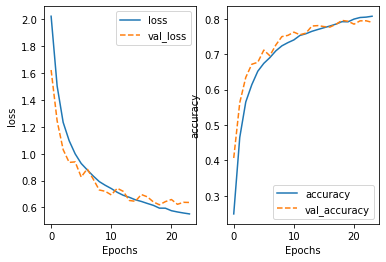

In [57]:
fig = plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], '-', label='loss')
plt.plot(history.epoch, history.history['val_loss'], '--', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
fig = plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], '-', label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '--', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [58]:
path_to_best_model = "path/to/best/model"
best_model = tf.keras.models.load_model(path_to_best_model)
best_model.evaluate(x_test,  y_test, verbose=2)

157/157 [==============================] - 2s 9ms/step - loss: 0.6546 - accuracy: 0.7903


[0.6545624732971191, 0.7903000116348267]

# 6. Transfer learning

In [96]:
resnet_backbone = tf.keras.applications.ResNet50V2(include_top=False,
                                                   input_shape=(64,64,3),
                                                   weights="imagenet")

In [97]:
resnet_classifier = tf.keras.Sequential([resnet_backbone,
                                         tf.keras.layers.GlobalAveragePooling2D(),
                                         tf.keras.layers.Dense(512, activation='relu'),
                                         tf.keras.layers.Dense(10, activation='softmax')])

In [98]:
resnet_classifier.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_29 (Dense)             (None, 10)                5130      
Total params: 24,619,018
Trainable params: 24,573,578
Non-trainable params: 45,440
_________________________________________________________________


In [99]:
# step 1. 텐서플로우 데이터셋 객체를 만듭니다.

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
num_train = len(train_ds)
print("학습데이터 수 : ", num_train)

# 학습셋, 검증셋 스플릿
val_ds = train_ds.take(int(num_train*0.2))
train_ds = train_ds.skip(int(num_train*0.2))

# 테스트셋
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

학습데이터 수 :  50000


In [100]:
# step 2. 데이터를 전처리합니다.

def augment(img,label):
    img = tf.image.resize_with_crop_or_pad(img, 32 + 4, 32 + 4) 
    # Random crop back to the original size
    img = tf.image.random_crop(img, size=[32, 32, 3])
    img = tf.image.random_brightness(img, 0.15)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    return img, label

def resize_image(img, label):
  img = tf.image.resize(img, [64,64], method='bicubic')
  return img, label

train_ds = train_ds.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(resize_image)

In [101]:
# step 3. 파이프라인을 최적화해줍니다.

train_ds = train_ds.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(64)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

resnet_classifier.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

class lrHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.lr = []        
    def on_epoch_begin(self, epoch, logs):
        self.lr.append(float(tf.keras.backend.get_value(self.model.optimizer.lr)))

lr_hist = lrHistory()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=5,
            verbose=1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="step6_{epoch}.h5",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    lr_hist
]
history = resnet_classifier.fit(train_ds, epochs=40, validation_data=val_ds,
                               callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 154s 188ms/step - loss: 1.1207 - accuracy: 0.6174 - val_loss: 1.0479 - val_accuracy: 0.6725

Epoch 00001: val_loss improved from inf to 1.04789, saving model to step6_1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
625/625 [==============================] - 117s 187ms/step - loss: 0.7747 - accuracy: 0.7372 - val_loss: 0.9812 - val_accuracy: 0.6750

Epoch 00002: val_loss improved from 1.04789 to 0.98120, saving model to step6_2.h5
Epoch 3/40
625/625 [==============================] - 117s 187ms/step - loss: 0.6589 - accuracy: 0.7793 - val_loss: 0.8190 - val_accuracy: 0.7340

Epoch 00003: val_loss improved from 0.98120 to 0.81895, saving model to step6_3.h5
Epoch 4/40
625/625 [==============================] - 117s 187ms/step - loss: 0.5811 - accuracy: 0.8032 - val_loss: 0.7213 - val_accuracy: 0.7583

Epoch 00004: val_loss improved from 0.81895 to 0.72134, saving model to step6_4.h5
Epoch 5/40
625/625 [==============================] - 117s 187ms/step - loss: 0.5248 - accuracy: 0.8211 - val_loss: 0.7404 - val_accuracy: 0.7626

Epoch 00005: val_loss did not improve from 0.72134
Epoch 6/40
625/625 [==============================] - 117s 187ms/step - loss: 0.4792 - accuracy: 0.8391 - val_lo